1.This Notebook is for Classification the dataset downloaded for the two classes of instruments.

In [79]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import utils
import random
import collections
import numpy
from sklearn import svm, tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from IPython.core.display import display, HTML

try:  # This is for compatiblitily python2/python3 of xrange function
    xrange
except NameError:
    xrange = range

2.Load previously created dataset

In [80]:
# Load dataset from saved file
DATASET_NAME = 'my_amazing_dataset'
dataset = utils.load_from_json('%s.json' % DATASET_NAME)
print('Loaded dataset with %i classes:' % len(dataset))
for klass, sounds in dataset.items():
    print('\t%s: %i sounds' % (klass, len(sounds)))
class_names = list(dataset.keys())  # This is just for convenience, reused later on

Loaded dataset with 2 classes:
	Plucked string instrument: 10 sounds
	Brass instrument: 10 sounds


3) Define vector space
Here we create a prototype feature vector that will define the way in which our documents are represented for classification purposes.

In [81]:
def build_tag_vector_space(n_dimensions, dataset, class_names): 
    # Get all tags in the dataset (the vocabulary)
    all_tags = list()
    for class_name in class_names:
        class_tags = utils.get_all_tags_from_class(class_name, dataset)
        all_tags += class_tags
        
    # Filter out tags with less frequency (get only top N tags)
    most_common_tags = [tag for tag, count in collections.Counter(all_tags).most_common(n_dimensions)]
    filtered_tags = [tag for tag in most_common_tags if tag in all_tags]
    
    # Build our prototype feature vector (unique list of tags), and print first 10 tags
    prototype_feature_vector = list(set(filtered_tags))
    print('Created prototype feature vector with %i dimensions (originally the space had %i dimensions)' % (
        len(prototype_feature_vector), len(set(all_tags))))
    print('Prototype vector tags (sorted by occurrence in filtered_tags):')
    for count, tag in enumerate(prototype_feature_vector):
        print('\t%i %s' % (count + 1, tag))
    return prototype_feature_vector


NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR = 110 # Maximum number of dimensions for the feature vector.

prototype_feature_vector = build_tag_vector_space(
    n_dimensions=NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR,
    dataset=dataset,
    class_names=class_names,
)

Created prototype feature vector with 88 dimensions (originally the space had 88 dimensions)
Prototype vector tags (sorted by occurrence in filtered_tags):
	1 chord
	2 wagner
	3 yellow
	4 horns
	5 children
	6 hunting
	7 call
	8 symphonic
	9 hornblowing
	10 c6
	11 A4
	12 beatles
	13 hit
	14 ukulele
	15 game
	16 midi-note-67
	17 hunting-horns
	18 vsco-2
	19 midi-velocity-31
	20 opera
	21 acoustic
	22 yellow-submarine
	23 crescendo
	24 tterd
	25 horn
	26 b3
	27 fanfare
	28 scale
	29 staccato
	30 french-horns
	31 siegfried-call
	32 G
	33 136466
	34 guitar
	35 vibrato-sustain
	36 midi-velocity-62
	37 c
	38 g
	39 strummed
	40 hunting-horn
	41 tone
	42 childrens
	43 coaching-days
	44 fsharp4
	45 from
	46 Ukulele
	47 Dsharp4
	48 neumann-U87
	49 submarine
	50 live
	51 music
	52 jingle
	53 uke
	54 F
	55 orchestral
	56 Guitar
	57 child
	58 c3
	59 F-major
	60 single-note
	61 milton
	62 french-horn
	63 Spongebob
	64 siegfried
	65 good-sounds
	66 mmerung
	67 intro
	68 ukelele
	69 g3
	70 mail-coach
	

5) Define train and testing set
In this cell we create the training and test sets that will be used to train our classifier and evaluate its accuracy.

PERCENTAGE_OF_TRAINING_DATA = 0.75 
MAX_INPUT_TAGS_FOR_TESTING = 110

Percentage of training data and test data is set here.  

In [82]:
def create_train_and_test_sets(dataset, class_names, percentage_training_data, 
                               max_input_tags_for_testing):
    training_set = dict()
    testing_set = dict()

    # Get 'n_training_sounds_per_class' sounds per class 
    for class_name, sounds in dataset.items():
        n_training_sounds_per_class = int(len(sounds) * percentage_training_data)
        sounds_from_class = sounds[:] # Copy the list so when we later shuffle it does not affect the original data 
        random.shuffle(sounds_from_class)
        training_set[class_name] = sounds_from_class[:n_training_sounds_per_class] # First sounds for training
        testing_set[class_name] = sounds_from_class[n_training_sounds_per_class:] # Following sounds for testing
     
        # Save a trimmed version of input tags for testing sounds
        for sound in testing_set[class_name]:
            sound['tags'] = random.sample(sound['tags'], min(max_input_tags_for_testing, len(sound['tags'])))

    print('Created training and testing sets with the following number of sounds:\n\tTrain\tTest')
    for class_name in class_names:
        training_sounds = training_set[class_name]
        testing_sounds = testing_set[class_name]
        print('\t%i\t%i\t%s' % (len(training_sounds), len(testing_sounds), class_name))
    return training_set, testing_set


PERCENTAGE_OF_TRAINING_DATA = 0.75 # Percentage of sounds that will be used for training (others are for testing)
MAX_INPUT_TAGS_FOR_TESTING = 110 # Use a big number to "omit" this parameter and use as many tags as originally are in the sound

training_set, testing_set = create_train_and_test_sets(
    dataset=dataset, 
    class_names=class_names,
    percentage_training_data=PERCENTAGE_OF_TRAINING_DATA,
    max_input_tags_for_testing=MAX_INPUT_TAGS_FOR_TESTING,
)

Created training and testing sets with the following number of sounds:
	Train	Test
	7	3	Plucked string instrument
	7	3	Brass instrument


6) Train classifier
Train the classifier with the training set that we prepared. User CLASSIFIER_TYPE is 'svm' here. 
 


In [83]:
def build_tag_feature_vector(sound):
    tag_features = utils.get_feature_vector_from_tags(sound['tags'], prototype_feature_vector)
    return np.concatenate([[], tag_features])

def train_classifier(training_set, classifier_type, class_names, dataset_name, feature_vector_func, 
                     feature_vector_dimension_labels=None, tree_max_depth=5):
    
    # Prepare data for fitting classifier (as sklearn classifiers require)
    classes_vector = list()
    feature_vectors = list()
    for class_name, sounds in training_set.items():
        for count, sound in enumerate(sounds):
            # Use index of class name in class_names as numerical value (classifier internally represents 
            # class label as number)
            classes_vector.append(class_names.index(class_name))
            feature_vector = feature_vector_func(sound)
            feature_vectors.append(feature_vector)

    # Create and fit classifier
    print('Training classifier (%s) with %i sounds...' % (CLASSIFIER_TYPE, len(feature_vectors)))
    if classifier_type == 'svm':
        classifier = svm.LinearSVC()
        classifier.fit(feature_vectors, classes_vector)
    elif classifier_type == 'tree':
        classifier = tree.DecisionTreeClassifier(max_depth=tree_max_depth)
        classifier.fit(feature_vectors, classes_vector)
        # Plot classifier decision rules
        # WARNING: do not run this if tree is too big, might freeze
        out_filename = '%s_tree_%i.png' % (dataset_name, random.randint(1000,9999))
        utils.export_tree_as_graph(
            classifier, feature_vector_dimension_labels, class_names=class_names, filename=out_filename)
        display(HTML('<h4>Learned tree:</h4><img src="%s"/>' % out_filename))
    else:
        raise Exception('Bad classifier type!!!')
    
    print('done!')
    return classifier

CLASSIFIER_TYPE = 'svm' # Use 'svm' or 'tree'

classifier = train_classifier(
    training_set=training_set,
    classifier_type=CLASSIFIER_TYPE, 
    class_names=class_names, 
    dataset_name=DATASET_NAME,
    feature_vector_func=build_tag_feature_vector,
    feature_vector_dimension_labels=prototype_feature_vector,  # This is used to show the class names in the tree image
)

Training classifier (svm) with 14 sounds...
done!


7) Evaluate classification
The function below evaluated the classifier build in the previous cell and shows some results.



Evaluating with 6 instances...
done!
5 correct predictions
1 wrong predictions
Overall accuracy 83.33%
Confussion matrix


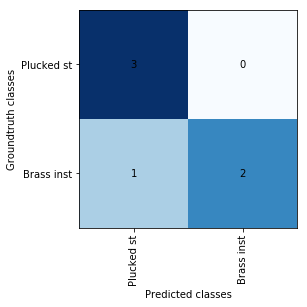

0.8333333333333334

In [84]:
def evaluate_classifier(testing_set, classifier, class_names, feature_vector_func, show_confussing_matrix=True):
    # Test with testing set
    print('Evaluating with %i instances...' % sum([len(sounds) for sounds in testing_set.values()]))
    predicted_data = list()
    for class_name, sounds in testing_set.items():
        for count, sound in enumerate(sounds):
            feature_vector = feature_vector_func(sound)
            predicted_class_name = class_names[classifier.predict([feature_vector])[0]]
            predicted_data.append((sound['id'], class_name, predicted_class_name))     
    print('done!')

    # Compute overall accuracy
    good_predictions = len([1 for sid, cname, pname in predicted_data if cname == pname])
    wrong_predictions = len([1 for sid, cname, pname in predicted_data if cname != pname])
    print('%i correct predictions' % good_predictions)
    print('%i wrong predictions' % wrong_predictions)
    accuracy = float(good_predictions)/(good_predictions + wrong_predictions)
    print('Overall accuracy %.2f%%' % (100 * accuracy))
    
    if show_confussing_matrix:
        # Compute confussion matrix (further analysis)
        matrix = list()
        for class_name in class_names:
            predicted_classes = list()
            for sid, cname, pname in predicted_data:
                if cname == class_name:
                    predicted_classes.append(pname)
            matrix.append([predicted_classes.count(target_class) for target_class in class_names])

        # Plot confussion matrix
        fig = plt.figure()
        plt.clf()
        ax = fig.add_subplot(111)
        ax.set_aspect(1)
        res = ax.imshow(matrix, cmap=plt.cm.Blues, interpolation='nearest')

        for x in xrange(len(matrix)):
            for y in xrange(len(matrix)):
                ax.annotate(str(matrix[x][y]), xy=(y, x), 
                            horizontalalignment='center',
                            verticalalignment='center')

        shortened_class_names = [item[0:10] for item in class_names]
        plt.xticks(range(len(class_names)), shortened_class_names, rotation=90)
        plt.yticks(range(len(class_names)), shortened_class_names)
        plt.xlabel('Predicted classes')
        plt.ylabel('Groundtruth classes')

        print('Confussion matrix')
        plt.show()
    
    return accuracy
    
evaluate_classifier(
    testing_set=testing_set,
    classifier=classifier,
    class_names=class_names,
    feature_vector_func=build_tag_feature_vector,
)

Using Different Classifiers for the same dataset to compare results.

SVM and Tree classifiers

Created prototype feature vector with 88 dimensions (originally the space had 88 dimensions)
Prototype vector tags (sorted by occurrence in filtered_tags):
	1 chord
	2 wagner
	3 yellow
	4 horns
	5 children
	6 hunting
	7 call
	8 symphonic
	9 hornblowing
	10 c6
	11 A4
	12 beatles
	13 hit
	14 ukulele
	15 game
	16 midi-note-67
	17 hunting-horns
	18 vsco-2
	19 midi-velocity-31
	20 opera
	21 acoustic
	22 yellow-submarine
	23 crescendo
	24 tterd
	25 horn
	26 b3
	27 fanfare
	28 scale
	29 staccato
	30 french-horns
	31 siegfried-call
	32 G
	33 136466
	34 guitar
	35 vibrato-sustain
	36 midi-velocity-62
	37 c
	38 g
	39 strummed
	40 hunting-horn
	41 tone
	42 childrens
	43 coaching-days
	44 fsharp4
	45 from
	46 Ukulele
	47 Dsharp4
	48 neumann-U87
	49 submarine
	50 live
	51 music
	52 jingle
	53 uke
	54 F
	55 orchestral
	56 Guitar
	57 child
	58 c3
	59 F-major
	60 single-note
	61 milton
	62 french-horn
	63 Spongebob
	64 siegfried
	65 good-sounds
	66 mmerung
	67 intro
	68 ukelele
	69 g3
	70 mail-coach
	

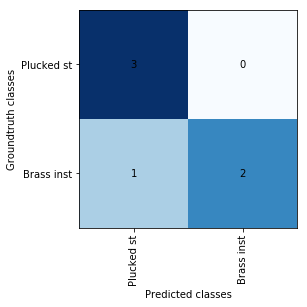

Created prototype feature vector with 88 dimensions (originally the space had 88 dimensions)
Prototype vector tags (sorted by occurrence in filtered_tags):
	1 chord
	2 wagner
	3 yellow
	4 horns
	5 children
	6 hunting
	7 call
	8 symphonic
	9 hornblowing
	10 c6
	11 A4
	12 beatles
	13 hit
	14 ukulele
	15 game
	16 midi-note-67
	17 hunting-horns
	18 vsco-2
	19 midi-velocity-31
	20 opera
	21 acoustic
	22 yellow-submarine
	23 crescendo
	24 tterd
	25 horn
	26 b3
	27 fanfare
	28 scale
	29 staccato
	30 french-horns
	31 siegfried-call
	32 G
	33 136466
	34 guitar
	35 vibrato-sustain
	36 midi-velocity-62
	37 c
	38 g
	39 strummed
	40 hunting-horn
	41 tone
	42 childrens
	43 coaching-days
	44 fsharp4
	45 from
	46 Ukulele
	47 Dsharp4
	48 neumann-U87
	49 submarine
	50 live
	51 music
	52 jingle
	53 uke
	54 F
	55 orchestral
	56 Guitar
	57 child
	58 c3
	59 F-major
	60 single-note
	61 milton
	62 french-horn
	63 Spongebob
	64 siegfried
	65 good-sounds
	66 mmerung
	67 intro
	68 ukelele
	69 g3
	70 mail-coach
	

done!
Evaluating with 6 instances...
done!
4 correct predictions
2 wrong predictions
Overall accuracy 66.67%
Confussion matrix


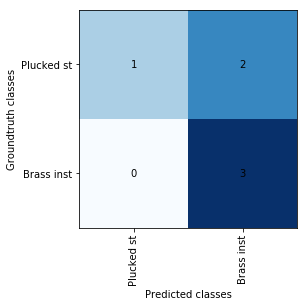

In [87]:
NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR = 109
PERCENTAGE_OF_TRAINING_DATA = 0.75
MAX_INPUT_TAGS_FOR_TESTING = 109

for classifier_type in ['svm', 'tree']:  
    display(HTML('<h2>With %s classifier</h2>' % classifier_type.upper()))

    prototype_feature_vector = build_tag_vector_space(
        n_dimensions=NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR,
        dataset=dataset,
        class_names=class_names,
    )
    training_set, testing_set = create_train_and_test_sets(
        dataset=dataset, 
        class_names=class_names,
        percentage_training_data=PERCENTAGE_OF_TRAINING_DATA,
        max_input_tags_for_testing=MAX_INPUT_TAGS_FOR_TESTING,   
    )
    classifier = train_classifier(
        training_set=training_set,
        classifier_type=classifier_type, 
        class_names=class_names, 
        dataset_name=DATASET_NAME,
        feature_vector_func=build_tag_feature_vector,
        feature_vector_dimension_labels=prototype_feature_vector,
    )
    evaluate_classifier(
        testing_set=testing_set,
        classifier=classifier,
        class_names=class_names,
        feature_vector_func=build_tag_feature_vector,
    )

Latent Semantic Analysis¶

In [64]:
# CODE FOR GENERATING FEATURE VECTORS WITH LATENT SEMANTIC ANALYSIS

def build_latent_semantic_analysis_feature_vectors(n_dimensions, training_set, testing_set):
    # Build latent semantic analysis (LSA) matrix factors
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, stop_words='english', analyzer='word', max_features=50000)
    svd = TruncatedSVD(n_components=n_dimensions, n_iter=7, random_state=42)

    # Compute LSA feature vectors for training set
    lsa_feature_vectors = list()
    lsa_feature_vectors_sound_ids = list()
    for class_name, sounds in training_set.items():
        for sound in sounds:
            lsa_feature_vectors.append(' '.join(sound['tags']))
            lsa_feature_vectors_sound_ids.append(sound['id'])
    X = vectorizer.fit_transform(lsa_feature_vectors)
    lsa_feature_vectors = svd.fit_transform(X)
    lsa_feature_vectors_dict = {sound_id:features for sound_id, features 
                                in zip(lsa_feature_vectors_sound_ids, lsa_feature_vectors)}

    # Now compute LSA feature vectors for testing set (using vectorizer and svd learnt for training set)
    lsa_feature_vectors = list()
    lsa_feature_vectors_sound_ids = list()
    for class_name, sounds in testing_set.items():
        for sound in sounds:
            lsa_feature_vectors.append(' '.join(sound['tags']))
            lsa_feature_vectors_sound_ids.append(sound['id'])
    X = vectorizer.transform(lsa_feature_vectors)
    lsa_feature_vectors = svd.transform(X)
    lsa_feature_vectors_dict.update({sound_id:features for sound_id, features 
                                     in zip(lsa_feature_vectors_sound_ids, lsa_feature_vectors)})

    print('Built LSA feature vectors for %i sounds!' % len(lsa_feature_vectors_dict))
    return lsa_feature_vectors_dict

Built LSA feature vectors for 20 sounds!
Created training and testing sets with the following number of sounds:
	Train	Test
	7	3	Plucked string instrument
	7	3	Brass instrument
Training classifier (tree) with 14 sounds...


done!
Evaluating with 6 instances...
done!
5 correct predictions
1 wrong predictions
Overall accuracy 83.33%
Confussion matrix


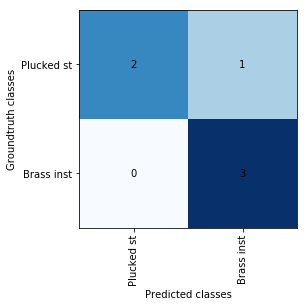

0.8333333333333334

In [90]:
# EXAMPLE EXPERIMENT USING LATENT SEMANTIC ANALYSIS

display(HTML('<h2>With Latent Semantic Analysis</h2>'))

NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR = 20
CLASSIFIER_TYPE = 'tree'
PERCENTAGE_OF_TRAINING_DATA = 0.75
MAX_INPUT_TAGS_FOR_TESTING = 40

def build_lsa_feature_vector(sound):
    lsa_features = lsa_feature_vectors_dict[sound['id']]
    return np.concatenate([[], lsa_features])

lsa_feature_vectors_dict = build_latent_semantic_analysis_feature_vectors(
    n_dimensions=NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR, training_set=training_set, testing_set=testing_set,)

training_set, testing_set = create_train_and_test_sets(
    dataset=dataset, class_names=class_names,
    percentage_training_data=PERCENTAGE_OF_TRAINING_DATA, max_input_tags_for_testing=MAX_INPUT_TAGS_FOR_TESTING)
classifier = train_classifier(
    training_set=training_set, classifier_type=CLASSIFIER_TYPE, class_names=class_names, dataset_name=DATASET_NAME,
    feature_vector_func=build_lsa_feature_vector,
)
evaluate_classifier(
    testing_set=testing_set, classifier=classifier, class_names=class_names, 
    feature_vector_func=build_lsa_feature_vector)

Using audio features as downloaded during dataset creation

In [67]:
# Expriment using duration

display(HTML('<h2>With Duration as feature</h2>'))

CLASSIFIER_TYPE = 'tree'
PERCENTAGE_OF_TRAINING_DATA = 0.75
NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR = 40
MAX_INPUT_TAGS_FOR_TESTING = 20

def build_feature_vector(sound):
    tag_features = utils.get_feature_vector_from_tags(sound['tags'], prototype_feature_vector)
    duration = sound['analysis']['sfx']['duration']
    # Some sounds seem to have no duration value (no analysis), in this case we sould probably remove them from the dataset
    return np.concatenate([[], tag_features, numpy.array([duration])])

# CODE TO CLEAN DATASET (remove sounds which do not have analysis information)
dataset_cleaned = {}
for key, sounds in dataset.items():
    if key not in dataset_cleaned:
        dataset_cleaned[key] = []
    for sound in sounds:
        if sound['analysis'] is not None:
            dataset_cleaned[key].append(sound)

prototype_feature_vector = []
prototype_feature_vector = build_tag_vector_space(
    n_dimensions=NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR,
    dataset=dataset,
    class_names=class_names
)

training_set, testing_set = create_train_and_test_sets(
    dataset=dataset_cleaned, class_names=class_names,
    percentage_training_data=PERCENTAGE_OF_TRAINING_DATA, max_input_tags_for_testing=MAX_INPUT_TAGS_FOR_TESTING)

feature_names = prototype_feature_vector[:]
feature_names.append('duration')
classifier = train_classifier(
    training_set=training_set, classifier_type=CLASSIFIER_TYPE, class_names=class_names, dataset_name=DATASET_NAME,
    feature_vector_func=build_feature_vector, feature_vector_dimension_labels=feature_names
)

evaluate_classifier(
    testing_set=testing_set, classifier=classifier, class_names=class_names, 
    feature_vector_func=build_feature_vector)

Created prototype feature vector with 40 dimensions (originally the space had 94 dimensions)
Prototype vector tags (sorted by occurrence in filtered_tags):
	1 concert
	2 chord
	3 strum
	4 horn-call
	5 160bpm
	6 horn
	7 horn-solo
	8 mezzoforte
	9 pitch
	10 d4
	11 trumpet
	12 strumming
	13 string
	14 pitch-bend
	15 delay
	16 neumann-U87
	17 spread
	18 A4
	19 non-vibrato
	20 single-note
	21 4
	22 electric
	23 ukulele
	24 valve-trill
	25 guitar
	26 midi-velocity-95
	27 multisample
	28 key-of-a
	29 power-chord
	30 brass
	31 distortion
	32 room-mic
	33 midi-note-67
	34 french-horn
	35 vsco-2
	36 arpeggio
	37 open-chords
	38 rock
	39 acoustic
	40 good-sounds
Created training and testing sets with the following number of sounds:
	Train	Test
	7	3	Plucked string instrument
	7	3	Brass instrument


KeyError: 'sfx'

In [ ]:
I am unable to detect why the code above is showing err as it should be fine.